# Dragon Week exploratory

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

pal = sns.color_palette("Set2")
sns.set()

In [2]:
dragons = pd.read_csv("dragon_week.csv", index_col=0)
dragons.columns = [c.replace("/2020", "") for c in dragons.columns]
dragons

,7/31,8/1,8/2,8/3,8/4,8/5,8/6,8/7
horsea,32,29,41,35,34,39,37,8
swablu,16,17,23,27,28,25,21,11
dratini,26,37,34,36,42,23,31,24
trapinch,24,23,25,35,20,15,21,11
bagon,20,20,19,22,15,13,9,7
gible,12,9,17,19,17,13,18,12
deino,0,0,1,7,6,3,5,1
total,130,135,160,181,162,131,142,74


**The key observation**: for the first two days of the Dragon Week event, the researchers hatched 0 Deino out of 270 eggs. In the third, they hatched 1 out of 160. And in the last five, they hatched 22 out of 690.

Niantic has been known to change shiny rates before. Did they do that again?

Resources:
 * [Bayesian Methods for Hackers](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb), Chapter 1, by Cam Davidson Pilon

In [3]:
dragons.columns

Index(['7/31', '8/1', '8/2', '8/3', '8/4', '8/5', '8/6', '8/7'], dtype='object')

<AxesSubplot:>

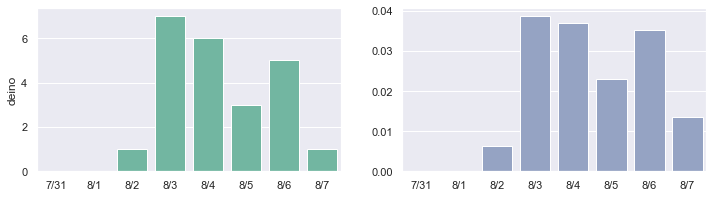

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(x=dragons.columns, y=dragons.loc["deino"], ax=ax[0], color=pal[0])
sns.barplot(x=dragons.columns, y=dragons.loc["deino"] / dragons.loc["total"], ax=ax[1], color=pal[2])

## Model
How would we model this?
 * we probably still want proportions, right?
 * there's some $p$ of hatching a Deino
 * if $p$ changed, there's a switchpoint at time $0 \leq t \leq 7$
 * which means we should model $p_{before}$ and $p_{after}$ separately
 
What about priors?
 * for probabilities, I almost always use Beta priors
 * for the switchpoint, there are only 8 options, so let's just use a (discrete) uniform prior over 0 through 7

Let's try it!

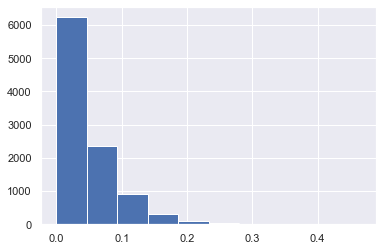

In [5]:
_ = plt.hist(pm.Beta.dist(1, 20).random(size=10_000))

In [6]:
with pm.Model() as model:
    p_before = pm.Beta("p_before", 1, 20)
    p_after = pm.Beta("p_after", 1, 20)
    switch = pm.DiscreteUniform("switch", 0, 7)
    
    # this essentially broadcasts the probability to the shape we want
    # while picking the right probability along the way
    index = np.arange(8)
    p = pm.Deterministic("p", pm.math.switch(switch >= index, p_before, p_after))
    
#     p = pm.Beta("p", 1, 2, shape=(8,))
    obs_deino = pm.Binomial("obs", dragons.loc["total"].values, p, observed=dragons.loc["deino"].values)
    

How did I know to use Slice sampling? https://cscherrer.github.io/post/bayesian-changepoint/. Google and trial and error :)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>Slice: [switch]
>Slice: [p_after]
>Slice: [p_before]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 33 seconds.


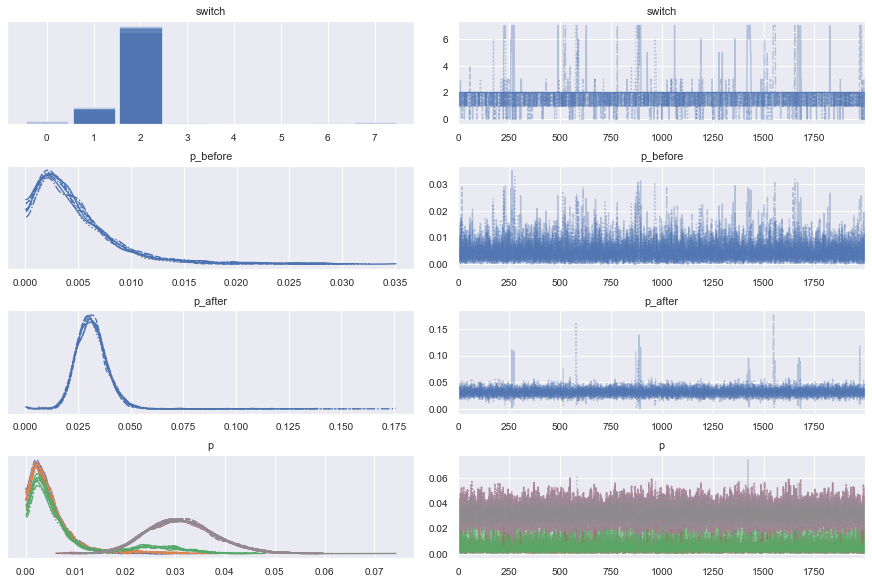

In [7]:
with model:
    trace = pm.sample(draws=2000, tune=1000, chains=8, step=pm.Slice())
    idata = az.from_pymc3(trace)
    
_ = az.plot_trace(idata, compact=True)

In [8]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

Text(0.5, 1.0, 'Probability of Deino hatch, before and after switchpoint')

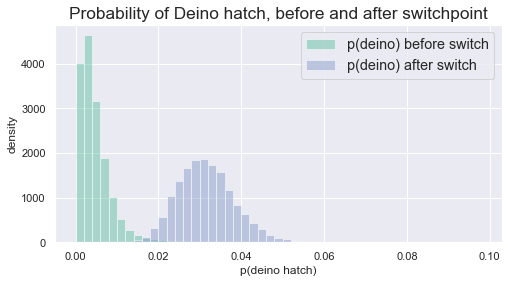

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(
    idata.posterior["p_before"].stack(sample=[...]).values,
    color=pal[0],
    alpha=0.5,
    label="p(deino) before switch",
    bins=np.arange(0, 0.1, 0.002),
)
ax.hist(
    idata.posterior["p_after"].stack(sample=[...]).values,
    color=pal[2],
    alpha=0.5,
    label="p(deino) after switch",
    bins=np.arange(0, 0.1, 0.002),
)

ax.legend(fontsize="large")
ax.set_xlabel("p(deino hatch)")
ax.set_ylabel("density")
ax.set_title("Probability of Deino hatch, before and after switchpoint", size="x-large")

## What about another species?

In [10]:
with pm.Model() as model:
    p_before = pm.Beta("p_before", 1, 20)
    p_after = pm.Beta("p_after", 1, 20)
    switch = pm.DiscreteUniform("switch", 0, 7)
    
    # this essentially broadcasts the probability to the shape we want
    # while picking the right probability along the way
    index = np.arange(8)
    p = pm.Deterministic("p", pm.math.switch(switch >= index, p_before, p_after))
    obs_gible = pm.Binomial("obs", dragons.loc["total"].values, p, observed=dragons.loc["gible"].values)
    
with model:
    idata_one = az.from_pymc3(pm.sample(draws=2000, tune=1000, chains=8, step=pm.Slice()))

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>Slice: [switch]
>Slice: [p_after]
>Slice: [p_before]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.


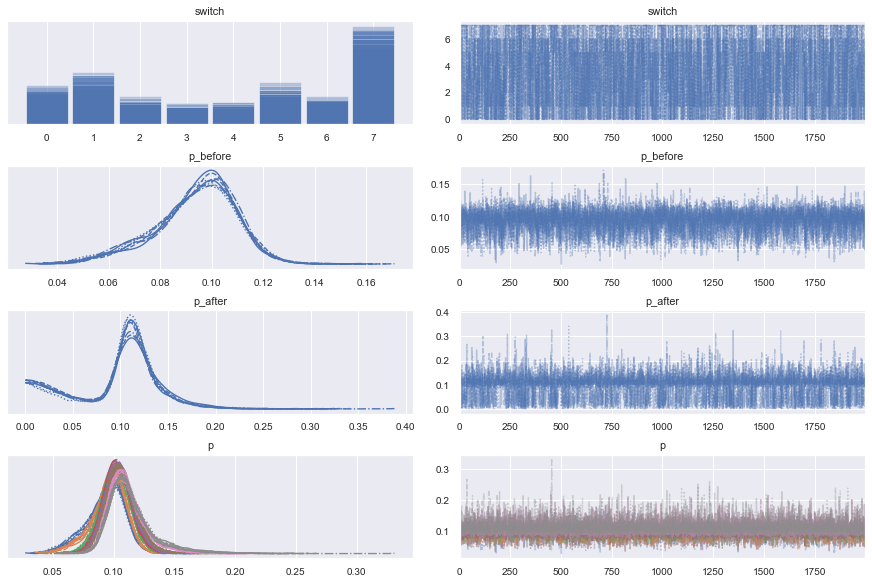

In [11]:
_ = az.plot_trace(idata_one, compact=True)

Text(0.5, 1.0, 'Probability of Gible hatch, before and after switchpoint')

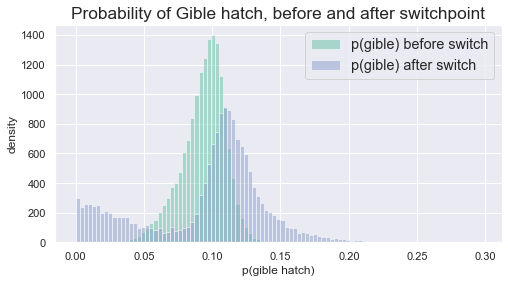

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(
    idata_one.posterior["p_before"].stack(sample=[...]).values,
    color=pal[0],
    alpha=0.5,
    label="p(gible) before switch",
    bins=np.arange(0, 0.3, 0.003),
)
ax.hist(
    idata_one.posterior["p_after"].stack(sample=[...]).values,
    color=pal[2],
    alpha=0.5,
    label="p(gible) after switch",
    bins=np.arange(0, 0.3, 0.003),
)

ax.legend(fontsize="large")
ax.set_xlabel("p(gible hatch)")
ax.set_ylabel("density")
ax.set_title("Probability of Gible hatch, before and after switchpoint", size="x-large")